In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import transformers


bert_base_model = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    print(df.head())
    return df

In [ ]:
def tokenize_texts(text, tokenizer, max_len):
    text = text.tolist()
    tokenized_output = tokenizer(
        text = text,
        padding='max_length',
        max_length=max_len,
        truncation=True,
        return_tensors='np',
        is_split_into_words=False,
        stride = 0,
        return_overflowing_tokens=False,
    )
    tokenized_input_ids = tokenized_output['input_ids']
    return tokenized_input_ids

In [ ]:
def split_data(df, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(df['article'], df['category'], test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
def one_hot_encode(labels, num_classes=10):
    one_hot_encoded_label = tf.keras.utils.to_categorical(labels, num_classes=num_classes, dtype='int32')
    return one_hot_encoded_label

In [ ]:
df = load_and_preprocess_data('data_preprocessed.csv')

X_train, X_test, y_train, y_test = split_data(df, test_size=0.2, random_state=42)

max_len = 60
tokenizer_x_train = tokenizer(
        text = X_train.astype('str').tolist(),
        padding='max_length',
        max_length=max_len,
        truncation=True,
        return_tensors='np',
        is_split_into_words=False,
        stride = 0,
        return_overflowing_tokens=False,
    )
X_train_tokenized = tokenizer_x_train['input_ids']

tokenizer_x_test = tokenizer(
        text = X_test.astype('str').tolist(),
        padding='max_length',
        max_length=max_len,
        truncation=True,
        return_tensors='np',
        is_split_into_words=False,
        stride = 0,
        return_overflowing_tokens=False,
    )
X_test_tokenized = tokenizer_x_test['input_ids']

encoder = LabelEncoder()
y_train_encoded = one_hot_encode(encoder.fit_transform(y_train))
y_test_encoded = one_hot_encode(encoder.transform(y_test))


        category                                            article
0         COMEDY  of the funniest tweets about cats and dogs thi...
1      PARENTING  the funniest tweets from parents this week sep...
2         SPORTS  maury wills basestealing shortstop for dodgers...
3  ENTERTAINMENT  golden globes returning to nbc in january afte...
4       POLITICS  biden says us forces would defend taiwan if ch...


In [ ]:
import tensorflow as tf

def construct_bert_based_classifier(bert_layer, total_classes=10):
    bert_input = tf.keras.layers.Input(shape=(60,), dtype=tf.int32, name='bert_input_layer')
    dropout_seq = tf.keras.layers.Dropout(0.3, name='dropout_for_generalization')(bert_layer(bert_input)[0][:, 0, :])
    prediction_layer = tf.keras.layers.Dense(total_classes, activation='softmax', name='prediction_layer')(dropout_seq)
    bert_classifier = tf.keras.Model(inputs=bert_input, outputs=prediction_layer)
    bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
    return bert_classifier

text_classification_model = construct_bert_based_classifier(bert_base_model)

text_classification_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert_input_layer (InputLay  [(None, 60)]              0         
 er)                                                             
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   335141888 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 60, 1024),                       
                              pooler_output=(None, 1             
                             024),                               
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [ ]:
# model train
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE

train_data = tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
test_data = tf.data.Dataset.from_tensor_slices((X_test_tokenized, y_test_encoded)).batch(BATCH_SIZE)

steps_per_epoch = 300
training_history = text_classification_model.fit(train_data, steps_per_epoch=steps_per_epoch, epochs=8)


Epoch 1/8


300/300 [==============================] - 447s 1s/step - loss: 0.8611 - accuracy: 0.7323
Epoch 2/8
300/300 [==============================] - 366s 1s/step - loss: 0.6433 - accuracy: 0.8039
Epoch 3/8
300/300 [==============================] - 366s 1s/step - loss: 0.6378 - accuracy: 0.8024
Epoch 4/8
300/300 [==============================] - 365s 1s/step - loss: 0.7635 - accuracy: 0.7568
Epoch 5/8
300/300 [==============================] - 366s 1s/step - loss: 0.5121 - accuracy: 0.8416
Epoch 6/8
300/300 [==============================] - 366s 1s/step - loss: 0.5232 - accuracy: 0.8358
Epoch 7/8
300/300 [==============================] - 365s 1s/step - loss: 0.5001 - accuracy: 0.8411
Epoch 8/8
300/300 [==============================] - 366s 1s/step - loss: 0.4844 - accuracy: 0.8480


In [ ]:
y_pred = text_classification_model.predict(X_test_tokenized)

869/869 [==============================] - 360s 408ms/step


In [ ]:
predictions = np.argmax(y_pred, axis=1)

In [ ]:
y_test

93521           WELLNESS
13402      ENTERTAINMENT
117826          BUSINESS
5399            POLITICS
75702           POLITICS
               ...      
96686       FOOD & DRINK
81887           WELLNESS
105613          BUSINESS
17749           POLITICS
70181     STYLE & BEAUTY
Name: category, Length: 27796, dtype: object

In [ ]:
y_prediction = [encoder.classes_[x] for x in predictions]
# y_true_value = [encoder.classes_[x] for x in y_test]
y_true_value = y_test.values

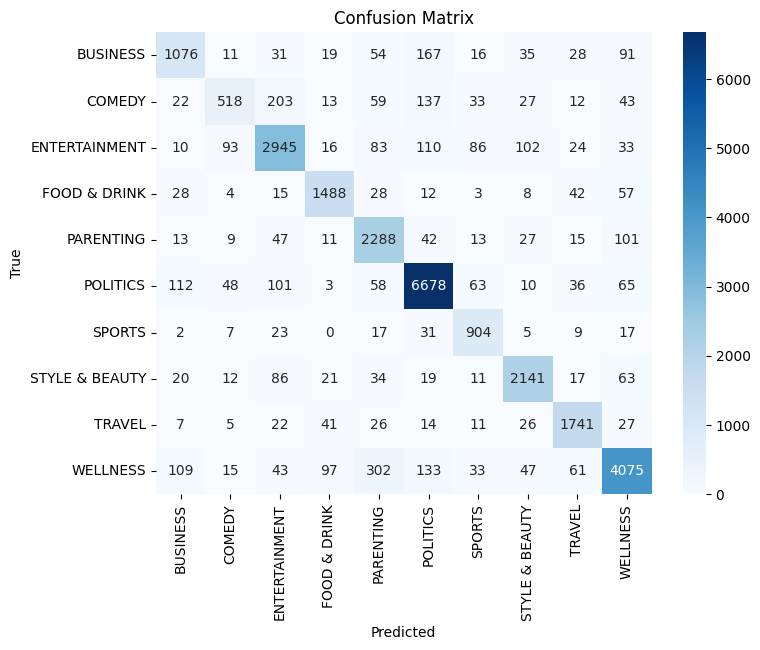

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true_value, y_prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# accuracy score
accuracy_score = sklearn.metrics.accuracy_score(y_true_value, y_prediction)
print("accuracy_score of test set:", accuracy_score)

accuracy_score of test set: 0.8581810332421931


In [ ]:
# classification report
print(classification_report(y_true_value, y_prediction, target_names=encoder.classes_))


                precision    recall  f1-score   support

      BUSINESS       0.77      0.70      0.74      1528
        COMEDY       0.72      0.49      0.58      1067
 ENTERTAINMENT       0.84      0.84      0.84      3502
  FOOD & DRINK       0.87      0.88      0.88      1685
     PARENTING       0.78      0.89      0.83      2566
      POLITICS       0.91      0.93      0.92      7174
        SPORTS       0.77      0.89      0.83      1015
STYLE & BEAUTY       0.88      0.88      0.88      2424
        TRAVEL       0.88      0.91      0.89      1920
      WELLNESS       0.89      0.83      0.86      4915

      accuracy                           0.86     27796
     macro avg       0.83      0.82      0.82     27796
  weighted avg       0.86      0.86      0.86     27796

